# Predict household income from satellite imagery data

First pass.

General ML pipeline steps:
1. Import data
2. Split data into test/train sets
3. Preprocess test/train sets separately
4. Generate features from data
5. For each regressor-hyperparameter combination:
    - Train regressor with given hyperparameters and training data and labels
    - Generate predicted labels for test data with trained regressor
    - Evaluate regressor-hyperparameter performance against actual test labels and get $R^2$
6. Explore best-performing models

In [224]:
import os
import math
import pickle
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn import preprocessing 
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import matplotlib.pyplot as plt

# Import configuration file
import config as cf

# Display options 
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = -1

# Turn off big pink warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Import data and drop "future" rows

In [225]:
#DATA_PATH = os.path.join('..', '..', '..', 'Data', 'FinalData', 'BISP', 'bisp_satellite_data_combined_buffer_1km.csv')
DATA_PATH = os.path.join('/Users/robmarty/Dropbox/World Bank/IEs/', 'Pakistan Poverty Estimation from Satellites', 'Data', 'FinalData', 'BISP', 'bisp_satellite_data_combined_buffer_1km.csv')
df = pd.read_csv(DATA_PATH)

# Remove Select Variables
df = df[df.columns.drop(list(df.filter(regex='2011')))]
df = df[df.columns.drop(list(df.filter(regex='2012')))]
df = df[df.columns.drop(list(df.filter(regex='2013')))]
df.shape

(33794, 59)

In [226]:
df = df.loc[df['period'].isin([2011, 2013])]
df = df.loc[df['period'].isin([2013])]
df = df.dropna(axis=0, subset=['hh_inc', 'viirs'])
df = df.dropna()
df.head()

,uid,period,LOCALITY,hh_inc,hh_inc_lastmonth,viirs_2014,viirs_2015,viirs_2016,viirs_2017,viirs_2018,dmspols_1992,dmspols_1993,dmspols_1994,dmspols_1995,dmspols_1996,dmspols_1997,dmspols_1998,dmspols_1999,dmspols_2000,dmspols_2001,dmspols_2002,dmspols_2003,dmspols_2004,dmspols_2005,dmspols_2006,dmspols_2007,dmspols_2008,dmspols_2009,dmspols_2010,viirs,dmspols,l7_1,l7_2,l7_3,l7_4,l7_5,l7_6,l7_7,l7_12,l7_13,l7_14,l7_15,l7_16,l7_17,l7_23,l7_24,l7_25,l7_26,l7_27,l7_34,l7_35,l7_36,l7_37,l7_45,l7_46,l7_47,l7_56,l7_57,l7_67
7,100389,2013,1,73000.0,6000.0,2.089507,2.307763,2.850603,3.653005,3.750000,43.0,33.666667,35.50,45.333333,40.0,33.166667,39.50,40.333333,37.333333,39.666667,38.833333,33.666667,34.00,34.50,40.666667,45.00,43.0,30.333333,46.0,2.141392,45.333333,951.897734,1282.748257,1417.251598,2574.000436,2469.137711,3000.408919,1889.609384,-0.148055,-0.196422,-0.460054,-0.443503,-0.518308,-0.330005,-0.049816,-0.334803,-0.316211,-0.401027,-0.191297,-0.289821,-0.270659,-0.358370,-0.142842,0.020793,-0.076494,0.153327,-0.097133,0.132958,0.227157
8,100401,2013,1,159000.0,13500.0,2.052437,2.296554,2.769960,3.702374,3.488333,43.0,33.666667,35.50,45.333333,40.0,33.166667,39.50,40.333333,37.333333,39.666667,38.833333,33.666667,34.00,34.50,40.666667,45.00,43.0,30.333333,46.0,2.133366,45.333333,941.063694,1268.392009,1402.777070,2547.212362,2463.117111,2998.701940,1876.871453,-0.148149,-0.196990,-0.460442,-0.447113,-0.522274,-0.332090,-0.050309,-0.335155,-0.320172,-0.405501,-0.193459,-0.289731,-0.274281,-0.362588,-0.144556,0.016784,-0.081409,0.151521,-0.098060,0.135080,0.230092
20,101101,2013,1,219000.0,21000.0,2.052437,2.296554,2.769960,3.702374,3.488333,43.0,33.666667,35.50,45.333333,40.0,33.166667,39.50,40.333333,37.333333,39.666667,38.833333,33.666667,34.00,34.50,40.666667,45.00,43.0,30.333333,46.0,2.133366,45.333333,940.979913,1268.248763,1401.871616,2547.740466,2459.946143,2998.786463,1874.074672,-0.148137,-0.196723,-0.460559,-0.446633,-0.522317,-0.331466,-0.050044,-0.335298,-0.319645,-0.405560,-0.192796,-0.290122,-0.273984,-0.362881,-0.144142,0.017532,-0.081320,0.152351,-0.098712,0.135180,0.230811
32,102103,2013,1,148000.0,13000.0,2.052437,2.296554,2.769960,3.702374,3.488333,43.0,33.666667,35.50,45.333333,40.0,33.166667,39.50,40.333333,37.333333,39.666667,38.833333,33.666667,34.00,34.50,40.666667,45.00,43.0,30.333333,46.0,2.133366,45.333333,940.630258,1267.752248,1400.750653,2547.949666,2457.645344,2998.886568,1871.886858,-0.148127,-0.196517,-0.460737,-0.446407,-0.522464,-0.331111,-0.049840,-0.335508,-0.319400,-0.405737,-0.192422,-0.290526,-0.273921,-0.363243,-0.143962,0.018041,-0.081296,0.152961,-0.099191,0.135294,0.231380
40,102237,2013,1,4500.0,88.0,1.968358,2.182109,2.637059,3.357345,3.315000,43.0,32.500000,34.25,43.000000,38.0,31.750000,38.25,38.750000,36.000000,38.250000,37.750000,32.000000,32.75,33.75,40.000000,43.75,42.5,30.000000,45.5,2.023836,44.500000,930.478318,1257.594150,1390.361758,2564.562136,2449.709546,2998.677095,1868.266880,-0.149500,-0.198154,-0.467544,-0.449452,-0.526372,-0.335075,-0.050140,-0.341945,-0.321559,-0.409063,-0.195361,-0.296896,-0.275867,-0.366439,-0.146658,0.022905,-0.078033,0.157077,-0.100758,0.134656,0.232263


## Transform Variables

In [316]:
#df.viirs = np.log(df.viirs+1)
#df.hh_inc = np.log(df.hh_inc+1)

a = df.hh_inc < 10
a.value_counts()

False    3751
True     1   
Name: hh_inc, dtype: int64

## 2. Split data into test/train

In [317]:
LABEL = 'hh_inc'
TEST_SIZE = 0.3

# Separate feature sets from label sets
x_df = df.drop(labels=[LABEL], axis=1)
scaler = preprocessing.MinMaxScaler() 
scaled_values = scaler.fit_transform(x_df) 
x_df.loc[:,:] = scaled_values

y_df = df[LABEL]

# Split into test and train sets for features and labels
x_train, x_test, y_train, y_test =  train_test_split(x_df, y_df, test_size=TEST_SIZE)

## Define Feature Groups

In [320]:
DAY_FEATURES = df.filter(regex='l7', axis=1).columns.tolist()
DAY_FEATURES_VIIRS = DAY_FEATURES + ['viirs', 'dmspols']
DAY_FEATURES_DMSPOLS = DAY_FEATURES + ['dmspols']

x_train_dayfeatures = x_train[DAY_FEATURES]
x_test_dayfeatures = x_test[DAY_FEATURES]

x_train_dayfeatures_viirs = x_train[DAY_FEATURES_VIIRS]
x_test_dayfeatures_viirs = x_test[DAY_FEATURES_VIIRS]

x_train_dayfeatures_dmspols = x_train[DAY_FEATURES_DMSPOLS]
x_test_dayfeatures_dmspols = x_test[DAY_FEATURES_DMSPOLS]

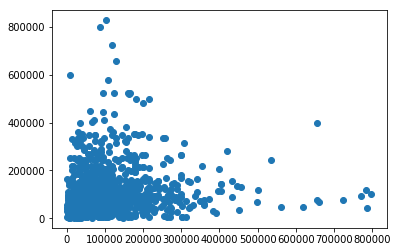

array([[1.        , 0.07047005],
       [0.07047005, 1.        ]])

In [323]:
regressor = DecisionTreeRegressor(max_depth=20)
trained = regressor.fit(x_train[DAY_FEATURES_VIIRS], y_train)
hh_income_predict = trained.predict(x_test[DAY_FEATURES_VIIRS])

from matplotlib import pyplot
pyplot.scatter(y_test, hh_income_predict)
pyplot.show()

np.corrcoef(y_test, hh_income_predict)

In [312]:
dim = x_train_dayfeatures_viirs.shape[1]

model = Sequential()
model.add(Dense(64, input_dim=dim, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))

opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

model.fit(x_train_dayfeatures_viirs.values, y_train.values, 
          validation_data=(x_test_dayfeatures_viirs.values, y_test.values), 
          epochs=20, batch_size=8)

Train on 2626 samples, validate on 1126 samples
Epoch 1/20
2626/2626 [==============================] - 1s - loss: 99.7179 - val_loss: 99.3894
Epoch 2/20
2626/2626 [==============================] - 0s - loss: 128.2994 - val_loss: 98.6082
Epoch 3/20
2626/2626 [==============================] - 0s - loss: 119.2170 - val_loss: 98.9462
Epoch 4/20
2626/2626 [==============================] - 0s - loss: 114.2856 - val_loss: 98.6417
Epoch 5/20
2626/2626 [==============================] - 0s - loss: 124.4372 - val_loss: 98.6064
Epoch 6/20
2626/2626 [==============================] - 0s - loss: 119.5093 - val_loss: 98.7658
Epoch 7/20
2626/2626 [==============================] - 0s - loss: 120.7372 - val_loss: 98.8706
Epoch 8/20
2626/2626 [==============================] - 0s - loss: 115.3997 - val_loss: 99.1103
Epoch 9/20
2626/2626 [==============================] - 0s - loss: 111.9004 - val_loss: 99.1684
Epoch 10/20
2626/2626 [==============================] - 0s - loss: 112.6513 - val_loss: 

In [313]:
hh_income_predict_nn = model.predict(x_test_dayfeatures_viirs.values)
hh_income_predict_nn

array([[40.70175 ],
       [38.392807],
       [74.06306 ],
       ...,
       [53.8414  ],
       [42.847916],
       [53.5972  ]], dtype=float32)

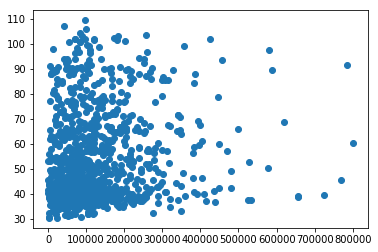

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [314]:
pyplot.scatter(y_test, hh_income_predict_nn)
pyplot.show()

np.corrcoef(y_test, hh_income_predict_nn)

In [311]:
hh_income_predict_nn.tolist()

TypeError: list indices must be integers or slices, not tuple

In [305]:
y_test.values.tolist()

[104000.0,
 118500.0,
 180000.0,
 55000.0,
 117000.0,
 260700.0,
 36000.0,
 93000.0,
 110000.0,
 67500.0,
 130000.0,
 52000.0,
 150000.0,
 7300.0,
 414000.0,
 120000.0,
 160000.0,
 204000.0,
 50000.0,
 25000.0,
 150000.0,
 3600.0,
 167000.0,
 144000.0,
 44000.0,
 228000.0,
 135200.0,
 9600.0,
 135000.0,
 270000.0,
 80000.0,
 13000.0,
 119600.0,
 97000.0,
 54500.0,
 69300.0,
 160000.0,
 60000.0,
 203500.0,
 25000.0,
 122000.0,
 95000.0,
 36000.0,
 43200.0,
 97000.0,
 104000.0,
 79000.0,
 126600.0,
 72000.0,
 102000.0,
 108000.0,
 380200.0,
 12000.0,
 108000.0,
 130000.0,
 216000.0,
 253000.0,
 55500.0,
 135000.0,
 84000.0,
 170000.0,
 80000.0,
 28500.0,
 55200.0,
 60000.0,
 64800.0,
 3000.0,
 120000.0,
 222800.0,
 47000.0,
 24000.0,
 15000.0,
 253000.0,
 80500.0,
 40500.0,
 57000.0,
 320000.0,
 102000.0,
 64000.0,
 120000.0,
 384000.0,
 126000.0,
 84400.0,
 150000.0,
 150000.0,
 50000.0,
 315000.0,
 118500.0,
 140000.0,
 135000.0,
 50100.0,
 174000.0,
 9000.0,
 12000.0,
 281000.0,
 4500